In [2]:
# activate ASTRAL/era5, using packages
cd(joinpath(homedir(), "Projects/ASTRAL/era5/src")) # working directory is src
using Pkg; Pkg.activate("..")    # Project is era5

using NCDatasets
using PyPlot
using Dates
# using FiniteDifferences
# using Plots

  Activating project at `~/Projects/ASTRAL/era5`


In [3]:
module Thermo
# thermodynamics of moist air functions

export theta_equiv

# constants
const Cp = 1005.7  # from my Davies-Jones function, was 1005.
const Cpv = 1870.0 # J/kg/K
const Cw  = 4190.0
const L0 = 2.501e6 # J/kg

const C = 273.15 # K

const Rd = 287.04
const Rv = 461.5
const RdoRv=Rd/Rv

"latent heat of water vapor"
LvK(TempK) = 2.501e6 + (Cpv-Cw) * (TempK-273.0)

"""
es(T,p) = is saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [Pa] (note the reversed input order), es [Pa]
Calling with optional keywords changes the units and
ignores the positional arguments.
es(T,p; TK=tk[Kelvin], P=pr[hPa])
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function es(T, p=1e5)
    # P in hPa
    P=p*1e-2
    esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # es in Pa
end

"es in hPa, same as keyword P[hPa]"
function es(T; P)
    # P in hPa
    esat =       6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # es in hPa, same as P
end

# # supply TK [Kelvin] by keyword, ignores positional T!!
# function es(T,p=1e5; TK=T+C, P=p*1e-2)
#     # P in hPa
#     T = TK - C
#     esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # convert es to Pa
# end

"""
qs(p,T) is saturation specific humidity based on Wexler's formula for es
with enhancement factor (see es.m).
p [Pa], T [degrees C], qs [kg/kg]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function qs(p,T)
    esat = es(T,p) # T[C], p[Pa] method
    qsat = RdoRv*esat / (p + (RdoRv-1)*esat)
end

"dqsdT(p,T[C]) derivative of qs with respect to T at p,T by autodiff of Bolton's qs"
dqsdT(p,T) = ForwardDiff.derivative(t -> qs(p,t), T)

# wet bulb temperature methods
# for approximating the evap process

"General single Newton iteration to update x toward f(x) = fhat for a univariate function f"
updatex(f, x, fhat) = x + (fhat-f(x)) / ForwardDiff.derivative(f, x)

"""
Twet_autodiff(T[K], q[kg/kg], p[Pa]; niter=2) wet bulb temperature using Newton's method
for target specific humidity q[kg/kg]. Uses automatic differntiation.
"""
function Twet_autodiff(T, q, p; niter=2)
    f(t) = (t - T) + LvK((T+t)/2)/Cp * (qs(p,t-C) - q)
    t=T
    for i in 1:niter
        t = updatex(f, t, 0)
    end
    t
end
# 2 iterations converges to ~0.001 K

# call as...
# q = rh*qs(pa, Ta)
# Twet_autodiff(Ta, rh*qs(pa, Ta-C), pa)


# thermo functions

"Exner(p/p0) = T/θ = (p/p0)^(Rd/Cp)"
Exner(p) = p^0.287
Exner(p, qv) = p ^ ((Rd/Cp) * (1 - 0.28*qv))

"potential temperature [K] = theta(T[K], p[hPa])"
theta(T, p) = T / Exner(p/1000.0)
theta(T, p, qv) = T / Exner(p/1000.0, qv)

"vapor pressure ev(p,qv); ev has units of p"
ev(p, qv) = p*qv / (RdoRv + qv)

"T[K] LCL from Bolton, Temp[K], ev[hPa]"
Tlcl(Temp, ev) = 2840/(3.5*log(Temp) - log(ev) - 4.805) + 55;
Tlcl(Temp, p, qv) = Tlcl(Temp, ev(p,qv))

"equivalent potential temperature"
function theta_equiv(T::Real, p::Real, qv::Real)
    Tl = Tlcl(T, p, qv)
    thetae = theta(T,p,qv) * exp((3376.0/Tl - 2.54) * qv * (1 + 0.81*qv))
end

# qs(1e2*1000, 290.0-C)
"equivalent saturated potential temperature theta_equiv_sat(T[K], p[hPa])"
theta_equiv_sat(T, p) = theta_equiv( T, p, qs(1e2*p, T-C) )

end # module Thermo

using .Thermo

In [4]:
# read one file

ncfile = filter(x->contains(x,"69e_2023") && endswith(x,".nc"), readdir())[1]
ds = NCDataset(ncfile)

Dataset: xsct_69e_2023.nc
Group: /

Dimensions
   longitude = 1
   latitude = 137
   level = 37
   time = 61

Variables
  longitude   (1)
    Datatype:    Float32 (Float32)
    Dimensions:  longitude
    Attributes:
     units                = degrees_east
     long_name            = longitude

  latitude   (137)
    Datatype:    Float32 (Float32)
    Dimensions:  latitude
    Attributes:
     units                = degrees_north
     long_name            = latitude

  level   (37)
    Datatype:    Int32 (Int32)
    Dimensions:  level
    Attributes:
     units                = millibars
     long_name            = pressure_level

  time   (61)
    Datatype:    DateTime (Int32)
    Dimensions:  time
    Attributes:
     units                = hours since 1900-01-01 00:00:00.0
     long_name            = time
     calendar             = gregorian

  d   (1 × 137 × 37 × 61)
    Datatype:    Union{Missing, Float64} (Int16)
    Dimensions:  longitude × latitude × level × time
    Attribute

In [5]:
# try unicodeplots
#= unicodeplots()
contour(ds["vo"][1,:,:,31])
=#
# not great for contours!

# matplotlib()

In [17]:
# try pyplot from Plots
#=
pyplot()
contourf(ds[:vo][1,:,:,31+4], 
    cmap = cgrad(:vik25),
    axis = ( font(12, "Times"), )) # doesn't know fonts
=#
# Plots complicates complicated PyPlot grammar

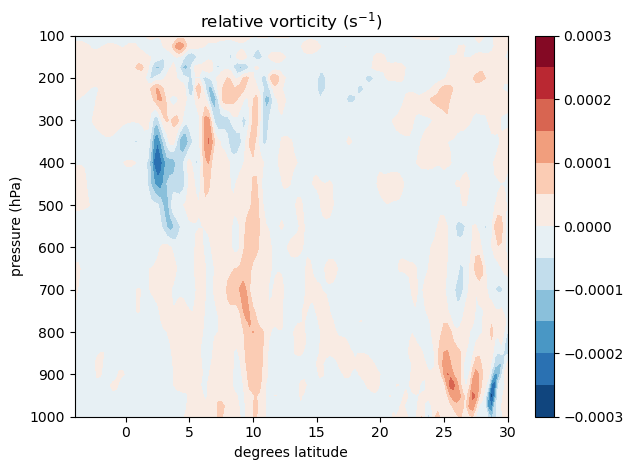

In [16]:
# plot relative vorticity

pd = permutedims
clf()
contourf(ds[:latitude][:], ds[:level][:],
    pd(ds[:vo][1,:,:,31+4]), 
    cmap=ColorMap("RdBu_r"), 
    # vmin=-3e-4, vmax=3e-4, 
    levels=1e-4*(-3:0.5:3) )
colorbar()
ylim([1000,100])
xlabel("degrees latitude")
ylabel("pressure (hPa)")
title("relative vorticity (s"*L"^{-1}"*")")
gcf()


In [18]:
# finite differences for arrays

const æ = 6.37e6 # radius of earth

"deprecated meridional derivative. ∂y(u) has same size as u"
function ∂y_old(u, y=ds[:latitude][:])
    # u = ds[:u][1,:,:,:] # eliminate singleton dim
    du = diff(u, dims=1)
    dy = æ * pi/180 * ([0; diff(y,dims=1)] .+ [diff(y,dims=1); 0])
    uy = zeros(size(u))
    uy[1:end-1,:,:] .= du
    uy[2:end,:,:] .+= du
    uy ./ dy
end

"""
Evaluate the vectorized operation f() along dimension dim of array x
looping over all other dimensions.
"""
function loopopdim(f, dim::Integer, x::AbstractArray)
    s = similar(x)
    Rpre = CartesianIndices(size(x)[1:dim-1])
    Rpost = CartesianIndices(size(x)[dim+1:end])
    _loopopdim!(f, s, x, Rpre, size(x, dim), Rpost)
end

function _loopopdim!(f, s, x, Rpre, n, Rpost)
    for Ipost in Rpost
        for Ipre in Rpre
            s[Ipre, :, Ipost] .= f( x[Ipre, :, Ipost] )
        end
    end
    s
end

"1st-order centered finite difference, padding end points with uncentered differences."
fdpad(x::Vector) = [ x[2]-x[1]; x[3:end].-x[1:end-2]; x[end]-x[end-1] ]

function ∂y(u=ds[:u][1,:,:,:], y=ds[:latitude][:])
    du =              loopopdim(fdpad, 1, u) 
    dy = æ * pi/180 * loopopdim(fdpad, 1, y)
    du ./ dy
end

# extend loopopdim to use like mapslices
"""
Evaluate the vectorized operation f(x,y) along dimension dim of array x
that matches vector y; looping over all other dimensions.
"""
function loopopdim(f, dim::Integer, x::AbstractArray, y::Vector)
    s = similar(x)
    Rpre = CartesianIndices(size(x)[1:dim-1])
    Rpost = CartesianIndices(size(x)[dim+1:end])
    _loopopdim!(f, s, x, Rpre, size(x, dim), Rpost, y)
end

function _loopopdim!(f, s, x, Rpre, n, Rpost, y)
    for Ipost in Rpost
        for Ipre in Rpre
            s[Ipre, :, Ipost] .= f( x[Ipre, :, Ipost], y )
        end
    end
    s
end

"∂logT/∂logp"
function ∂lnp(t=log.(ds[:t][1,:,:,:]), p=ds[:level][:])
    dlnT = loopopdim(fdpad, 2, t)
    dlnp = loopopdim(fdpad, 1, log.(p))
    # dlnTdlnp = loopopdim(./, 2, dlnT, dlnp ) # broadcast /dlnp along 2d dim of dlnT
    # mapslices of a broadcasting function !! yay !!
    dTdlnp = mapslices(x->x./dlnp, dlnT, dims=2)
end

∂lnp

In [19]:
# compute the finite differences
dlnTdy = ∂y( log.(ds[:t][1,:,:,:]) )
dudy = ∂y( ds[:u][1,:,:,:] )
dvdx = ds[:vo][1,:,:,:] .+ dudy

# compare old and new methods
maximum(abs, ∂y_old( ds[:u][1,:,:,:] ) .- dudy ) # tiny, 10^-19

dlnTdlnp = ∂lnp( log.(ds[:t][1,:,:,:]) )

137×37×61 Array{Float64, 3}:
[:, :, 1] =
  0.00168162  -0.0179212  -0.0795899  …  0.191117  0.191198  0.18969
  0.0037321   -0.0181717  -0.0796986     0.195133  0.187578  0.185132
  0.00519636  -0.0183406  -0.0800209     0.188786  0.192935  0.193267
  0.00594408  -0.0183918  -0.0806225     0.197526  0.190774  0.191218
  0.00607278  -0.0184441  -0.0814098     0.207499  0.190911  0.186545
  0.00584309  -0.0186393  -0.0822086  …  0.190272  0.19123   0.192719
  0.00546168  -0.0190006  -0.082833      0.183422  0.17316   0.191394
  0.00509182  -0.0193634  -0.0831996     0.186612  0.160894  0.179144
  0.00470138  -0.0194569  -0.0833095     0.19058   0.166609  0.183215
  0.0040953   -0.0190988  -0.0831804     0.189626  0.168835  0.185854
  ⋮                                   ⋱            ⋮         
 -0.0030624   -0.0308737  -0.113846      0.19541   0.283063  0.289963
 -0.00310471  -0.0322727  -0.113264      0.205048  0.282363  0.291196
 -0.00310484  -0.0335093  -0.112498   …  0.213939  0.27848

In [9]:
# compute characteristic frequencies for dry symmetric instabilities
# in the meridional-vertical plane (69E)
# Bennetts and Hoskins 1979
# Assume ERA5 is geostrophic zonal base state flow field.

const grav = 9.8 
const Rd = 287.0
const Cp = 1005.0
RdoCp = Rd/Cp
const Ω = 7.2921159e-5 # s-1

# buoyancy frequency squared
N² = @. grav^2 / (Rd*ds[:t][1,:,:,:]) * (RdoCp - dlnTdlnp) # s-2

# inertial frequency squared
fCoriolis(y) = 2*Ω*sind(y)
F2fcn(f, dudy) = f*(f-dudy)
F² = mapslices(dudy-> F2fcn.(fCoriolis.(ds[:latitude][:]), dudy), dudy, dims=1)

# thermal wind (shear)
S² = -grav * dlnTdy # = f du/dz

# Ertel potential vorticity
q = @. F²*N² - S²*S²

σ_min² = @. ( N² + F² - sqrt((N² + F²)^2 - 4*q) )/2 # s^-2, +imaginary part indicates unstable growth
σ_unst = @. sqrt( Complex(σ_min²) ) # frequency of least stable symmetric mode

137×37×61 Array{ComplexF64, 3}:
[:, :, 1] =
 7.23656e-5+0.0im  5.46406e-5+0.0im         …  7.84552e-5+0.0im
 7.21122e-5+0.0im  5.46042e-5+0.0im            7.61879e-5+0.0im
 7.14191e-5+0.0im  5.49704e-5+0.0im            7.38926e-5+0.0im
 6.96332e-5+0.0im  5.53877e-5+0.0im              6.617e-5+0.0im
 6.74194e-5+0.0im   5.6467e-5+0.0im             6.0842e-5+0.0im
 6.53644e-5+0.0im  5.79584e-5+0.0im         …  5.89435e-5+0.0im
 6.39418e-5+0.0im  5.91184e-5+0.0im            6.54118e-5+0.0im
 6.34914e-5+0.0im  6.00652e-5+0.0im             7.1745e-5+0.0im
 6.39403e-5+0.0im  6.11424e-5+0.0im            7.16755e-5+0.0im
 6.47679e-5+0.0im   6.2061e-5+0.0im            6.71409e-5+0.0im
           ⋮                                ⋱  
 7.78166e-6+0.0im         0.0+1.42041e-5im            0.0+0.00221143im
  9.0341e-6+0.0im         0.0+1.44589e-5im            0.0+0.0025024im
 1.01451e-5+0.0im         0.0+1.47713e-5im  …         0.0+0.00212162im
 1.10167e-5+0.0im         0.0+1.49519e-5im            0.

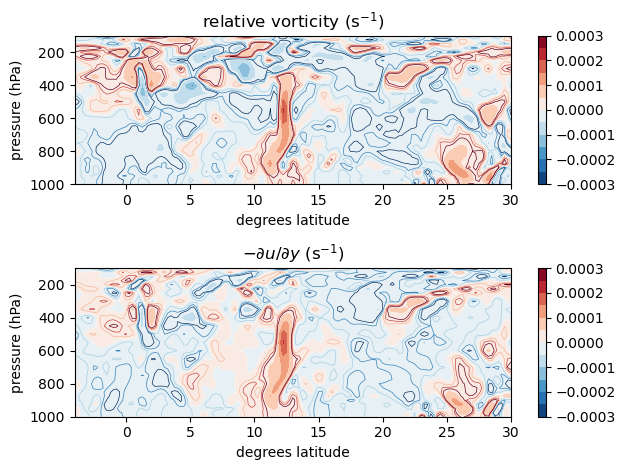

In [21]:
# plot vorticity and meridional shear of zonal velocity

it = findfirst(dt -> dt>=DateTime(2023,6,6,0,0,0), ds[:time][:] )

clf()
subplot(2,1,1)
contourf(ds[:latitude][:], ds[:level][:],
    pd(ds[:vo][1,:,:,it]), 
    cmap=ColorMap("RdBu_r"), 
    # vmin=-3e-4, vmax=3e-4, 
    levels=1e-4*(-3:0.5:3) )
colorbar()
contour(ds[:latitude][:], ds[:level][:],
    pd(ds[:vo][1,:,:,it]), 
    cmap=ColorMap("RdBu_r"), 
    # vmin=-3e-4, vmax=3e-4, 
    levels=1e-5*(-3:3),
    linewidths=0.5 )
ylim([1000,100])
xlabel("degrees latitude")
ylabel("pressure (hPa)")
title("relative vorticity (s"*L"^{-1}"*")")

subplot(2,1,2)
contourf( ds[:latitude][:], ds[:level][:], 
    pd(-dudy[:,:,it]),
   #vmin=-3e-4, vmax=3e-4,
    levels=1e-4.*(-3:0.5:3),
    cmap=ColorMap("RdBu_r"))
colorbar()
contour( ds[:latitude][:], ds[:level][:], 
    pd(-dudy[:,:,it]),
    #vmin=-3e-4, vmax=3e-4,
    levels=1e-5.*(-3:3),
    cmap=ColorMap("RdBu_r"),
    linewidths=0.5 )
ylim([1000, 100])
xlabel("degrees latitude")
ylabel("pressure (hPa)")
title(L"-\partial u/\partial y"*" (s"*L"^{-1}"*")")
tight_layout()
gcf()

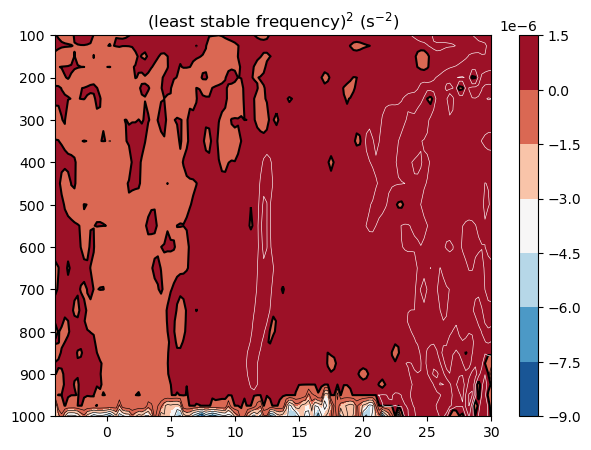

In [22]:
# plot the dry stability analysis

clf()
contourf(ds[:latitude][:], ds[:level][:], pd(σ_min²[:,:,it]),
    cmap=ColorMap("RdBu_r"))
colorbar()
contour(ds[:latitude][:], ds[:level][:], pd(σ_min²[:,:,it]),
    colors="k", levels=(0,))
contour(ds[:latitude][:], ds[:level][:], pd(imag.(σ_unst[:,:,it])),
    colors="k", linewidths=0.45, levels=0.5e-3:0.5e-3:3e-3)
contour(ds[:latitude][:], ds[:level][:], pd(real.(σ_unst[:,:,it])),
    colors="w", linewidths=0.45, levels=0.5e-4:0.25e-4:3e-4)
ylim([1000, 100])
title(L"(least stable frequency)$^2$ (s$^{-2}$)")
gcf()

In [23]:
1/.5e-3 / 60
# 6-30 h instability growth time scale

33.333333333333336

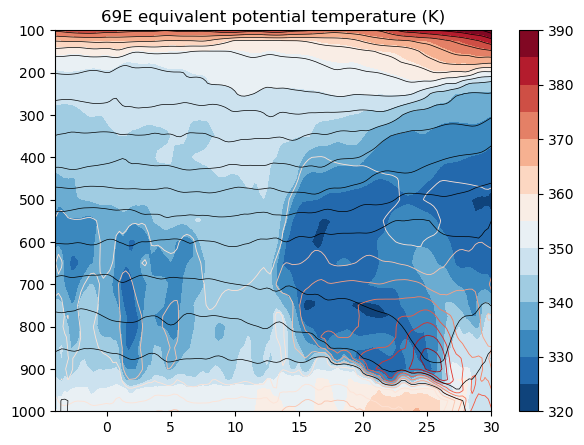

In [24]:
# equivalent potential temperatures
θe = let p = ds[:level][:], t = ds[:t][1,:,:,:], q = ds[:q][1,:,:,:]
    Thermo.theta_equiv.(t,pd(p),max.(0.0,q))
end
θes = let p = ds[:level][:], t = ds[:t][1,:,:,:]
    Thermo.theta_equiv_sat.(t,pd(p))
end

dlnθedlnp = ∂lnp( log.(θe) )

clf()
contourf(ds[:latitude][:], ds[:level][:], pd(θe[:,:,it]),
    cmap=ColorMap("RdBu_r"), levels=320:5:390)
colorbar()
contour(ds[:latitude][:], ds[:level][:], pd(θes[:,:,it]-θe[:,:,it]),
    cmap=ColorMap("Reds"), linewidths=0.6, levels=0:10:90)
contour(ds[:latitude][:], ds[:level][:], 
    pd(Thermo.theta.(ds[:t][1,:,:,it],pd(ds[:level][:]))),
    colors="k", linewidths=0.5, levels=280:5:420)
ylim([1000, 100])
title("69E equivalent potential temperature (K)")
gcf()

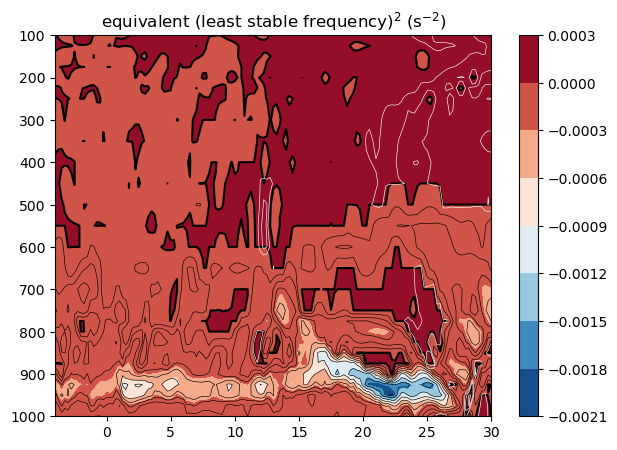

In [25]:
# equivalent buoyancy frequency (for saturated latent heating) 
Nequiv² = @. -grav^2 / (Rd*ds[:t][1,:,:,:]) * dlnθedlnp # s-2

# Ertel equivalent potential vorticity
qe = @. F²*Nequiv² - S²*S²

# (meridional) symmetric oscillation frequency
σe_min² = @. ( Nequiv² + F² - sqrt((Nequiv² + F²)^2 - 4*qe) )/2 # s^-1, +imaginary part indicates unstable growth
σe_unst = @. sqrt( Complex(σe_min²) ) # frequency of least stable symmetric mode

# plot equivalent stability analysis
clf()
contourf(ds[:latitude][:], ds[:level][:], pd(σe_min²[:,:,it]),
    cmap=ColorMap("RdBu_r"), levels=-21e-4:3e-4:3e-4)
colorbar()
# contour(ds[:latitude][:], ds[:level][:], pd(Nequiv²[:,:,it]),
#     colors="r", linestyles="-", linewidths=1, levels=-21e-4:3e-4:3e-4)
contour(ds[:latitude][:], ds[:level][:], pd(σe_min²[:,:,it]),
    colors="k", levels=(0,))
contour(ds[:latitude][:], ds[:level][:], pd(imag.(σe_unst[:,:,it])),
    colors="k", linewidths=0.45, levels=0.5e-2:0.5e-2:5e-2)
contour(ds[:latitude][:], ds[:level][:], pd(real.(σe_unst[:,:,it])),
    colors="w", linewidths=0.45, levels=0.5e-4:0.25e-4:3e-4)
ylim([1000, 100])
title(L"equivalent (least stable frequency)$^2$ (s$^{-2}$)")
gcf()

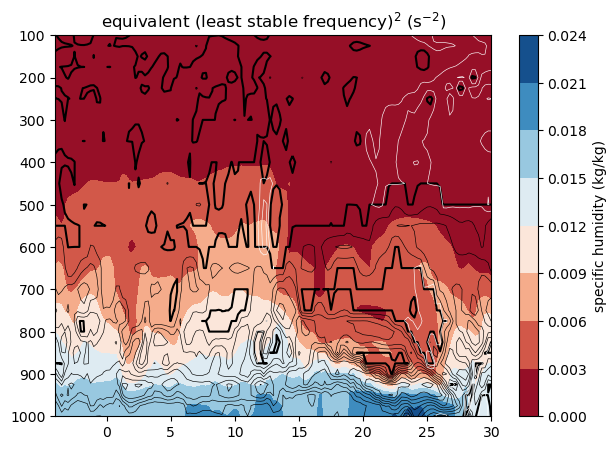

In [26]:
# plot stability contours over specific humidity
clf()
contourf(ds[:latitude][:], ds[:level][:], pd(ds[:q][1,:,:,it]),
    cmap=ColorMap("RdBu"))
cb = colorbar(label="specific humidity (kg/kg)")
contour(ds[:latitude][:], ds[:level][:], pd(σe_min²[:,:,it]),
    colors="k", levels=(0,))
contour(ds[:latitude][:], ds[:level][:], pd(imag.(σe_unst[:,:,it])),
    colors="k", linewidths=0.45, levels=0.5e-2:0.5e-2:5e-2)
contour(ds[:latitude][:], ds[:level][:], pd(real.(σe_unst[:,:,it])),
    colors="w", linewidths=0.45, levels=0.5e-4:0.25e-4:3e-4)
ylim([1000, 100])
title(L"equivalent (least stable frequency)$^2$ (s$^{-2}$)")
gcf()